Other analyses of the same data:

https://github.com/charlie1347/TfL_bikes

https://medium.com/@AJOhrn/data-footprint-of-bike-sharing-in-london-be9e11425248

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import set_matplotlib_formats

In [2]:
# For pretty and exportable matplotlib plots.
# If you are running this yourself and want interactivity,
# try `%matplotlib widget` instead.
set_matplotlib_formats("svg")
%matplotlib inline
# Set a consistent plotting style across the notebook using Seaborn.
sns.set_style("darkgrid")
sns.set_context("notebook")

In [3]:
bikefolder = "./data/bikes"

In [103]:
def add_station_names(stations_names, df, namecolumn, idcolumn):
    namemaps = (
        df[[idcolumn, namecolumn]]
        .groupby(idcolumn)
        .aggregate(lambda x: x.unique())
    )
    for number, names in namemaps.iterrows():
        current_names = station_names.get(number, set())
        # The following two lines are a stupid dance around the annoying fact that pd.unique sometimes returns a single value,
        # sometimes a numpy array of values, but since the single value is a string, it too is an iterable.
        vals = names[0]
        new_names = set([vals]) if type(vals) == str else set(vals)
        current_names.update(new_names)
        station_names[number] = current_names


def clean_datetime_column(df, colname, roundto="H"):
    # A bit of a hacky way to use the first entry to figure out which date format this file uses.
    # Not super robust, but works. TODO Improve this.
    if len(df[colname].iloc[0]) > 16:
        format = "%d/%m/%Y %H:%M:%S"
    else:
        format = "%d/%m/%Y %H:%M"
    df[colname] = pd.to_datetime(df[colname], format=format)
    df[colname] = df[colname].dt.round(roundto)
    early_cutoff = pd.datetime(2010, 7, 30)  # When the program started.
    late_cutoff = pd.datetime(2020, 1, 1)  # Approximately now.
    df = df[(late_cutoff > df[colname]) & (df[colname] >= early_cutoff)]
    return df


def compute_single_events(df, which):
    stationcol = "{}Station Id".format(which)
    datecol = "{} Date".format(which)
    events = (
        df.rename(columns={stationcol: "Station", datecol: "Date"})
        .groupby(["Date", "Station"])
        .size()
        .unstack("Station")
    )
    return events


def compute_both_events(df):
    ends = compute_single_events(df, "End")
    starts = compute_single_events(df, "Start")
    both = (
        pd.concat([ends, starts], keys=["End", "Start"], axis=1)
        .reorder_levels([1, 0], axis=1)
        .fillna(0.0)
    )
    return both


def castable_to_int(obj):
    try:
        int(obj)
        return True
    except ValueError:
        return False


def cast_to_int(df, colname):
    try:
        df = df.astype({colname: np.int_}, copy=False)
    except ValueError:
        castable_rows = df[colname].apply(castable_to_int)
        df = df[castable_rows]
        df = df.astype({colname: np.int_}, copy=False)
    return df


events_by_station_path = Path("./events_by_station.p")
if events_by_station_path.exists():
    events_by_station = pd.read_pickle(events_by_station_path)
else:
    datafiles = sorted(os.listdir(bikefolder))
    folderpath = Path(bikefolder)
    datapaths = [folderpath / Path(file) for file in datafiles]
    datapaths = [p for p in datapaths if p.suffix == ".csv"]

    station_names = {}

    pieces = []
#     datapaths = [
#         folderpath / Path(file)
#         for file in [
#             "21JourneyDataExtract31Aug2016-06Sep2016.csv",
#             "15JourneyDataExtract20Jul2016-26Jul2016.csv",
#             "13b. Journey Data Extract 22Dec14-03Jan15.csv",
#             "16JourneyDataExtract27Jul2016-02Aug2016.csv",
#             "10b. Journey Data Extract 28Sep14-11Oct14.csv",
#             "6. Journey Data Extract_27May-23Jun12.csv",
#             "6. Journey Data Extract_27May-23Jun12.csv",
#         ]
#     ]
    cols = [
        "End Date",
        "EndStation Id",
        "EndStation Name",
        "Start Date",
        "StartStation Id",
        "StartStation Name",
    ]
    problem_paths = []
    for path in datapaths:
        print(path)
        try:
            df = pd.read_csv(path, usecols=cols, encoding="ISO-8859-2")
        except ValueError as e:
            # Some files have missing or abnormaly named columns. We'll deal with them later.
            problem_paths.append(path)
            continue
        # Drop any rows that have missing values.
        df = df[~df.isna().any(axis=1)]
        # Cast the columns to the right types. This is easier ones NAs have been dropped.
        df = cast_to_int(df, "EndStation Id")
        df = cast_to_int(df, "StartStation Id")
        # Turn the date columns from strings into datetime objects rounded to the hour.
        df = clean_datetime_column(df, "End Date")
        df = clean_datetime_column(df, "Start Date")
        events = compute_both_events(df)
        pieces.append(events)

        add_station_names(
            station_names, df, "EndStation Name", "EndStation Id"
        )
        add_station_names(
            station_names, df, "StartStation Name", "StartStation Id"
        )

    station_ids = {}
    for k, v in station_names.items():
        v = sorted(v)
        station_names[k] = v
        for name in v:
            station_ids[name] = k

    def get_station_id(name):
        try:
            return station_ids[name]
        except KeyError:
            return "NA"

    print("Doing the problem cases ({} of them).".format(len(problem_paths)))
    safe_cols = [
        "End Date",
        "EndStation Name",
        "Start Date",
        "StartStation Name",
    ]
    for path in problem_paths:
        print(path)
        df = pd.read_csv(path, usecols=safe_cols, encoding="ISO-8859-2")
        # Drop any rows that have missing values.
        df = df[~df.isna().any(axis=1)]
        # Add a column of station ids, based on names.
        df["EndStation Id"] = df["EndStation Name"].apply(get_station_id)
        df["StartStation Id"] = df["StartStation Name"].apply(get_station_id)
        # Turn the date columns from strings into datetime objects rounded to the hour.
        format_datetime_column(df, "End Date")
        format_datetime_column(df, "Start Date")
        events = compute_both_events(df)
        pieces.append(events)

    events_by_station = pd.concat(pieces).fillna(0.0).sort_index()

    events_by_station.to_pickle(events_by_station_path)

In [104]:
events_by_station

Station              1          2          3          4          5          \
                     End Start  End Start  End Start  End Start  End Start   
Date                                                                         
2011-03-10 23:00:00  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   
2012-01-04 00:00:00  0.0   0.0  0.0   0.0  0.0   1.0  1.0   0.0  0.0   0.0   
2012-01-04 01:00:00  0.0   0.0  0.0   0.0  0.0   0.0  1.0   0.0  0.0   0.0   
2012-01-04 02:00:00  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   
2012-01-04 03:00:00  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   
...                  ...   ...  ...   ...  ...   ...  ...   ...  ...   ...   
2017-05-16 22:00:00  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   
2017-05-16 23:00:00  0.0   0.0  1.0   0.0  0.0   1.0  0.0   0.0  1.0   0.0   
2017-05-17 00:00:00  0.0   0.0  0.0   2.0  0.0   0.0  0.0   0.0  0.0   0.0   
2017-05-17 01:00:00  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   
2017-05-17 02:00:00  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   

Station              ...  817        818        819        820        821  \
                     ...  End Start  End Start  End Start  End Start  End   
Date                 ...                                                    
2011-03-10 23:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   
2012-01-04 00:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   
2012-01-04 01:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   
2012-01-04 02:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   
2012-01-04 03:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   
...                  ...  ...   ...  ...   ...  ...   ...  ...   ...  ...   
2017-05-16 22:00:00  ...  2.0   0.0  0.0   0.0  0.0   1.0  2.0   0.0  0.0   
2017-05-16 23:00:00  ...  0.0   0.0  0.0   0.0  0.0   4.0  1.0   0.0  0.0   
2017-05-17 00:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   
2017-05-17 01:00:00  ...  0.0   0.0  0.0   0.0  2.0   0.0  0.0   0.0  0.0   
2017-05-17 02:00:00  ...  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   

Station                    
                    Start  
Date                       
2011-03-10 23:00:00   0.0  
2012-01-04 00:00:00   0.0  
2012-01-04 01:00:00   0.0  
2012-01-04 02:00:00   0.0  
2012-01-04 03:00:00   0.0  
...                   ...  
2017-05-16 22:00:00   0.0  
2017-05-16 23:00:00   0.0  
2017-05-17 00:00:00   0.0  
2017-05-17 01:00:00   0.0  
2017-05-17 02:00:00   0.0  

[55903 rows x 1608 columns]

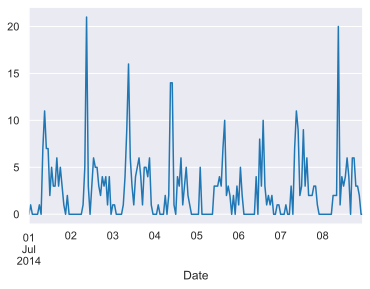

In [46]:
events_by_station[(15.0, "End")].loc["2014-07-01":"2014-07-08"].plot()

In [106]:
events_total = events_by_station.sum(axis=1, level=1)

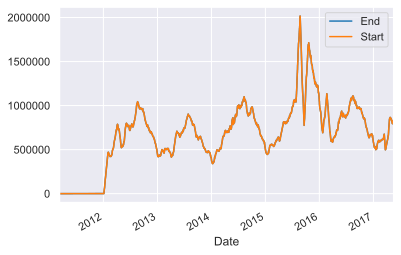

In [114]:
events_total.rolling("28d").sum().plot()